In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 13.1

In [2]:
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7     # correlation between intercepts and slopes

#### Code 13.2

In [3]:
Mu = [a, b]  

#### Code 13.3

In [4]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 13.4

The code 13.4 and the related comment in the book is particular to R and not relevant for Python.

#### Code 13.5

In [5]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6

In [6]:
N_cafes = 20

#### Code 13.7

In [7]:
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

#### Code 13.8

In [8]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

#### Code 13.9

Instead of using confidence region ellipses (Seaborn doesn't have this functionality)
we'll be using KDEs. To make the kde smoother we will use a sample size larger than the one `vary_effects`

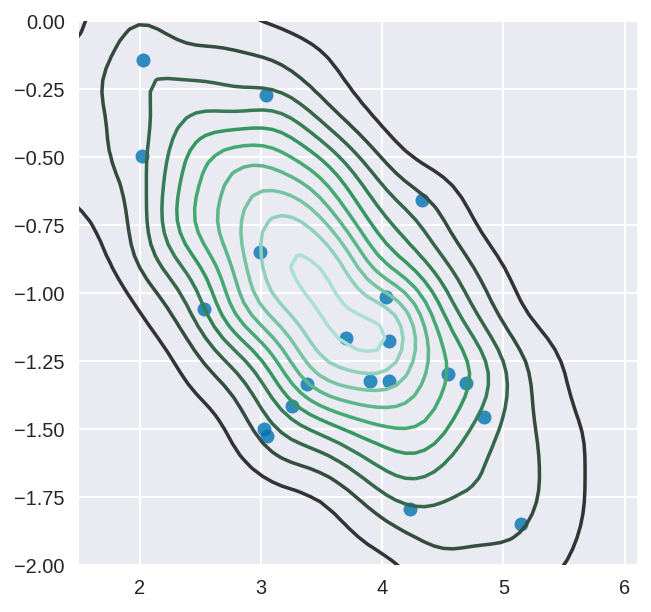

In [9]:
np.random.seed(42)
vary_effects_larger = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=2000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(vary_effects_larger, ax=ax)  # KDE plot (substitute for confidence ellipses)
sns.regplot(a_cafe, b_cafe, fit_reg=False, ax=ax);  # scatter plot with no regression line
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2, 0);

#### Code 13.10

In [10]:
N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))

#### Code 13.11

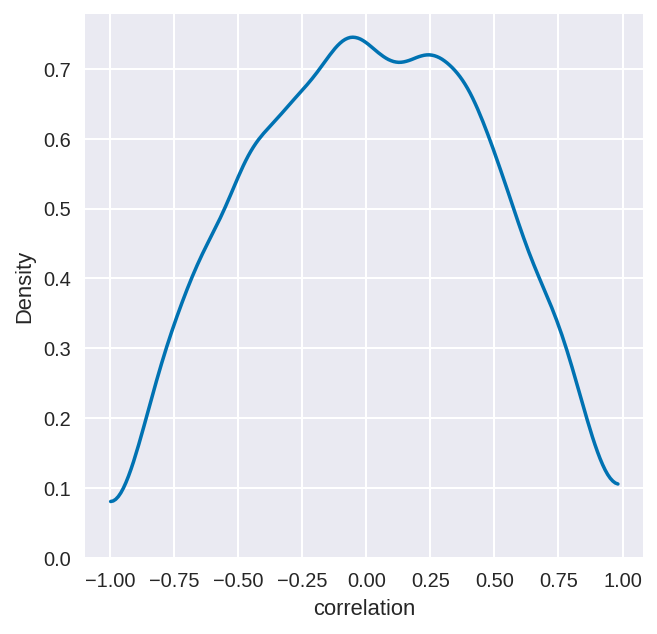

In [11]:
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.kdeplot(R, ax=ax);
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

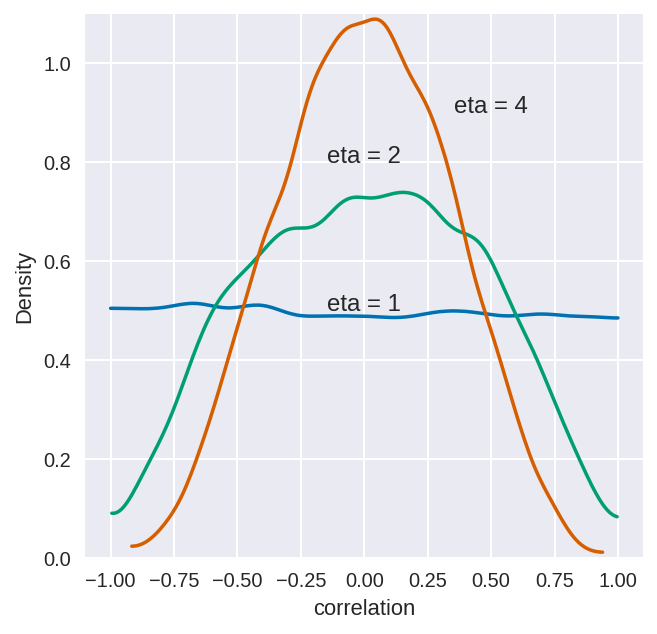

In [12]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, .5], [0, .8], [.5, .9]]
for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(R, ax=ax);
    ax.text(loc[0], loc[1], 'eta = %s'%(eta), horizontalalignment='center')

ax.set_ylim(0, 1.1)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.12

In [16]:
cafe_idx = d['cafe'].values
with pm.Model() as hierarchical_model:
    sd_dist = pm.HalfCauchy.dist(beta=1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations etc
    sigma_ab = pm.Deterministic('sigma_ab',tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('r', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  # prior for average intercept and slope
    
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    sd = pm.HalfCauchy('sd', beta=1)      # prior stddev within cafes
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  # likelihood
    

In [17]:
# Run inference. 
with hierarchical_model:
    trace = pm.sample(3e3, tune=1000, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000.0 [00:48<00:00, 81.82it/s] 


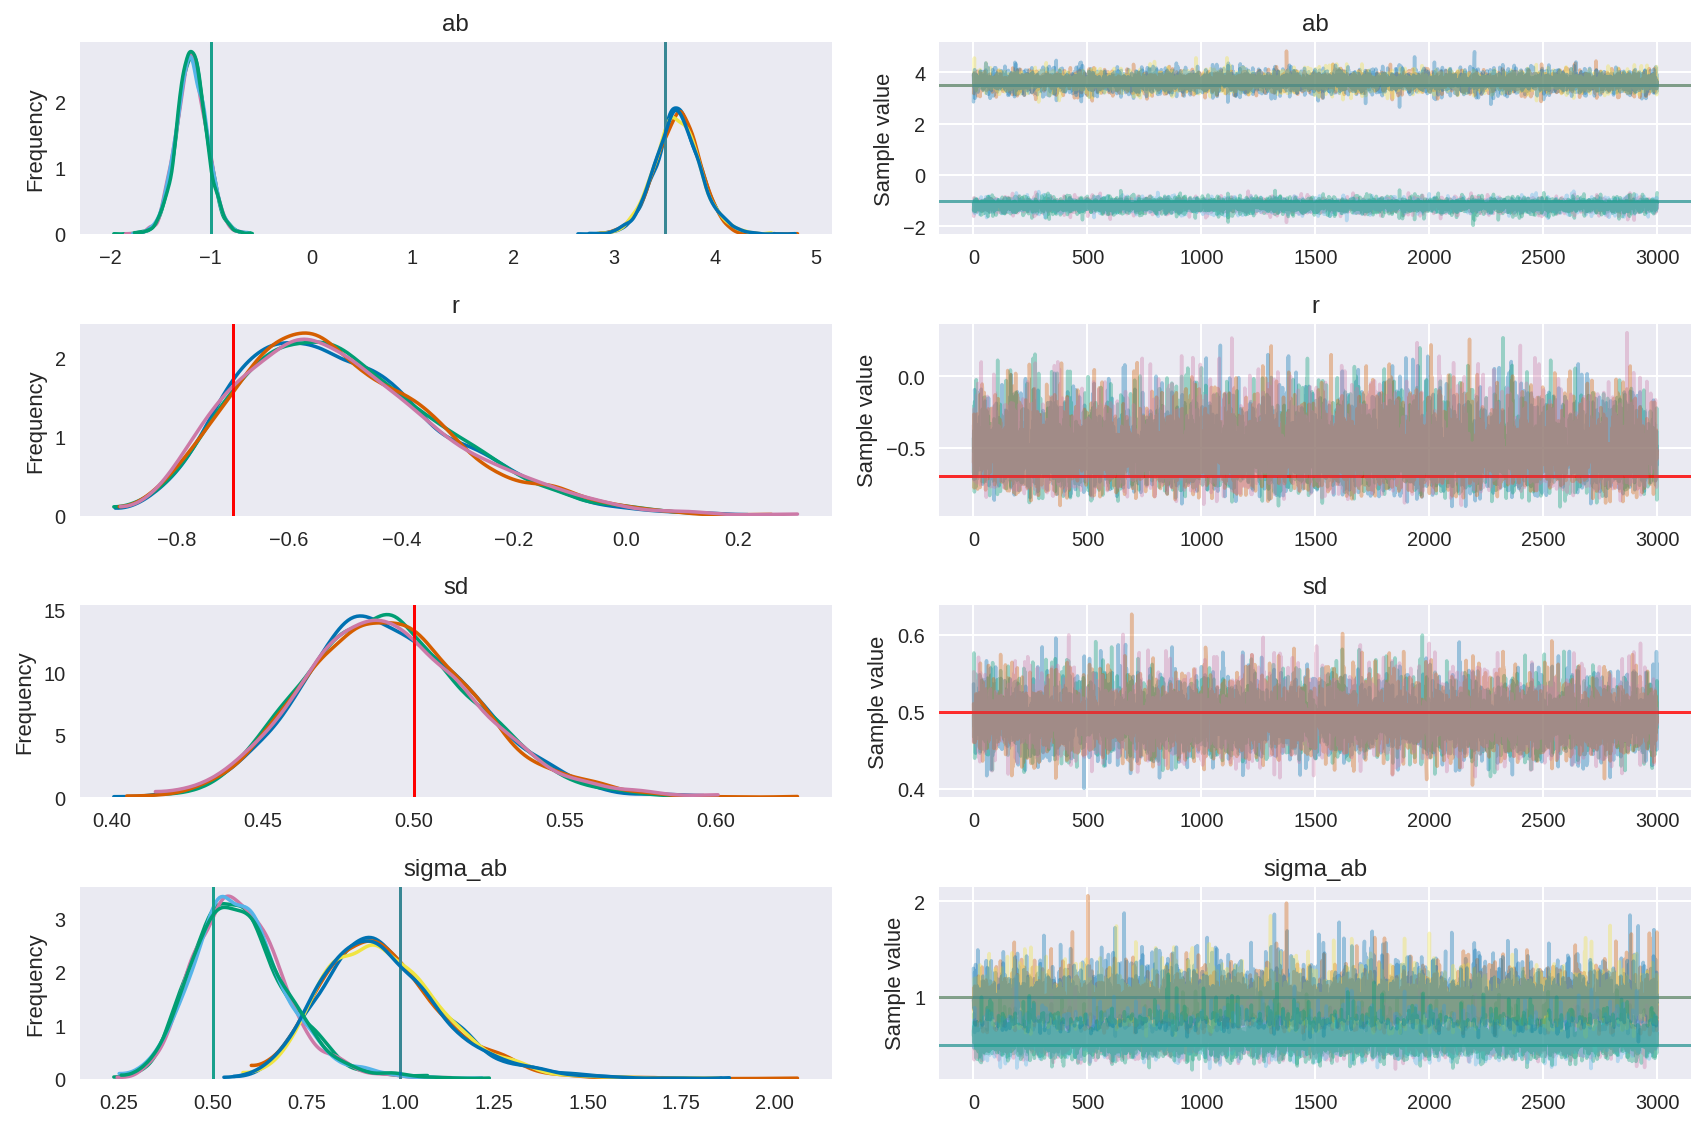

In [18]:
burnin=0
pm.traceplot(trace[burnin:], varnames=['ab', 'r', 'sd', 'sigma_ab'],
            lines={"ab": Mu,
                   "r": rho,
                   "sd": sigma,
                   "sigma_ab": sigmas});

Looks good! The model seems to be able to recover the initial values `a`, `b`, `rho` and `sigma`s.

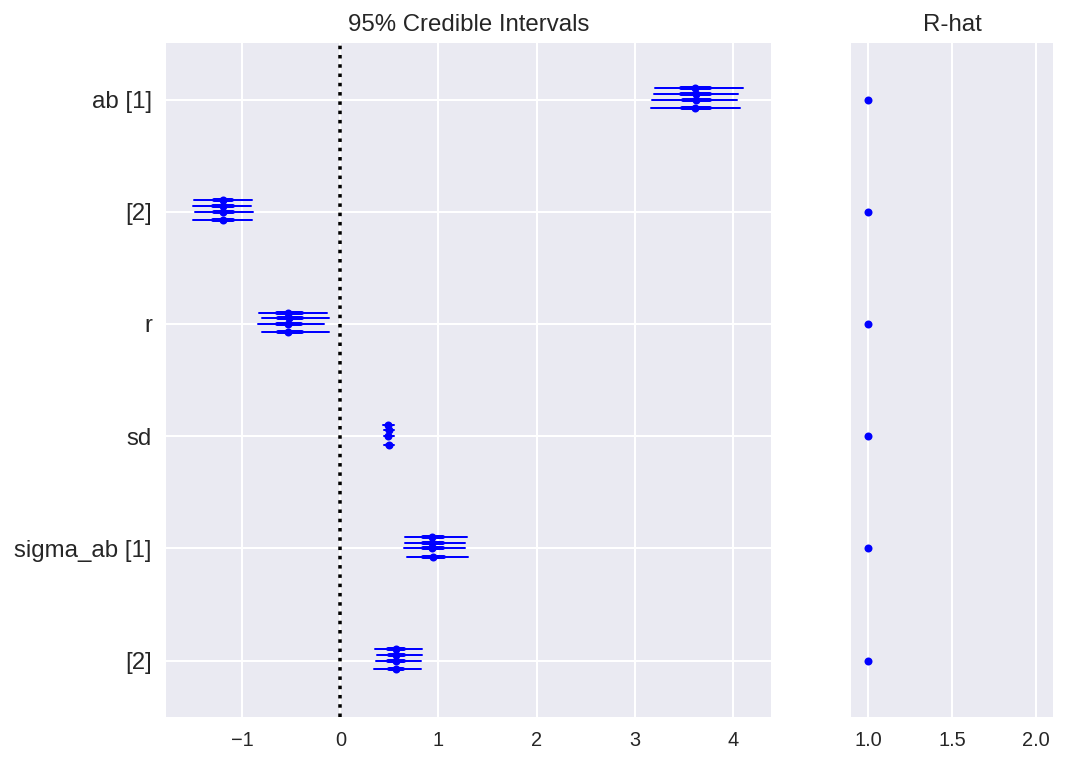

In [19]:
pm.forestplot(trace[burnin:], varnames=['ab', 'r', 'sd', 'sigma_ab']);

In [20]:
trace_df = pm.trace_to_dataframe(trace[burnin:])
trace_df.head()

,sigma_ab__0,sigma_ab__1,ab__0,ab__1,chol_cov__0,chol_cov__1,chol_cov__2,sd,ab_cafe__0_0,ab_cafe__0_1,...,ab_cafe__15_1,ab_cafe__16_0,ab_cafe__16_1,ab_cafe__17_0,ab_cafe__17_1,ab_cafe__18_0,ab_cafe__18_1,ab_cafe__19_0,ab_cafe__19_1,r__0
0,1.299585,0.595703,2.844019,-1.123900,1.299585,-0.401047,0.440481,0.536527,2.528660,-0.418491,...,-1.158175,3.191264,-1.399836,2.173382,-0.689522,3.300475,-1.615514,5.364423,-2.083214,-0.673233
1,1.040241,0.747575,3.576264,-1.137191,1.040241,-0.295682,0.686615,0.501014,2.701083,-0.562646,...,-0.693003,3.605937,-1.542115,2.375223,-0.709385,3.179769,-1.950572,4.837046,-2.522957,-0.395522
2,0.967190,0.592962,3.939631,-1.418402,0.967190,-0.426383,0.412069,0.481966,2.526865,-0.111775,...,-1.094204,3.483977,-1.464317,2.952427,-1.406209,3.069962,-1.955819,4.418936,-1.533447,-0.719073
3,0.887358,0.826938,3.639999,-1.439890,0.887358,-0.312105,0.765779,0.493811,2.760708,-1.005539,...,-0.734110,3.468796,-1.750026,2.456382,-1.066293,3.220638,-2.010682,4.337879,-1.311653,-0.377423
4,1.278708,0.455574,3.566242,-1.157696,1.278708,-0.293741,0.348229,0.461623,2.545051,-0.166531,...,-0.548928,3.582019,-1.572467,2.541338,-1.380152,3.222743,-1.557340,4.448485,-1.121051,-0.644772


In [15]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running Ubuntu 16.04 and using:
Python 3.5.2
IPython 6.2.1
PyMC3 3.2
NumPy 1.13.3
SciPy 0.19.1
Matplotlib 2.1.0+224.g95805d2
Seaborn 0.7.1

